In [1]:
from z3 import *
import numpy as np
import random
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

# our library
from sat_metropolis import smt, mcmc, utils

In [2]:
# We create five Integer variables
num_vars = 5*2
x = [Int(f'x{i}') for i in range(num_vars)] # (age, sex)

s = Solver() # get an instance of a Z3 solver

# model constraints
s.add(0<=x[0])
s.add(x[0]<=x[1])
s.add(x[1]<=x[2])
s.add(x[2]==30) #  median
s.add(x[2]<=x[3])
s.add(x[3]<=x[4])
s.add(x[4]<=125)

s.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) #average

for i in range(5,10):
    s.add(0<=x[i])
    s.add(x[i]<=1)

s.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

s.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males


In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='megasampler',
                                           z3_problem=s,
                                           timeout_sampler=60*10)

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 20
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 10
Reals 0
Formula tree depth 6
--------------------------------------------
starting MeGASampler
Formula is satisfiable
MAX-SMT returned 'unknown' (timeout?)
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 403.933
epoch time: 599.937
grow_seed time: 17.0412
initial_solving time: 0.0128394
output time: 0.899084
start_epoch time: 195.92
total time: 600.006
Epochs: 88115
MAX-SMT calls: 88116
SMT calls: 1
Assignments considered (with repetitions): 8987629
Models (with repetitions): 8987628
Unique models (# samples in file): 482
-----------------------------------
The parameter `solver_samples` only contains 482 samples. Thus, every chain will contain 482 instead of 482. Try running the SAT/SMT sampler longer to obtain more samples.



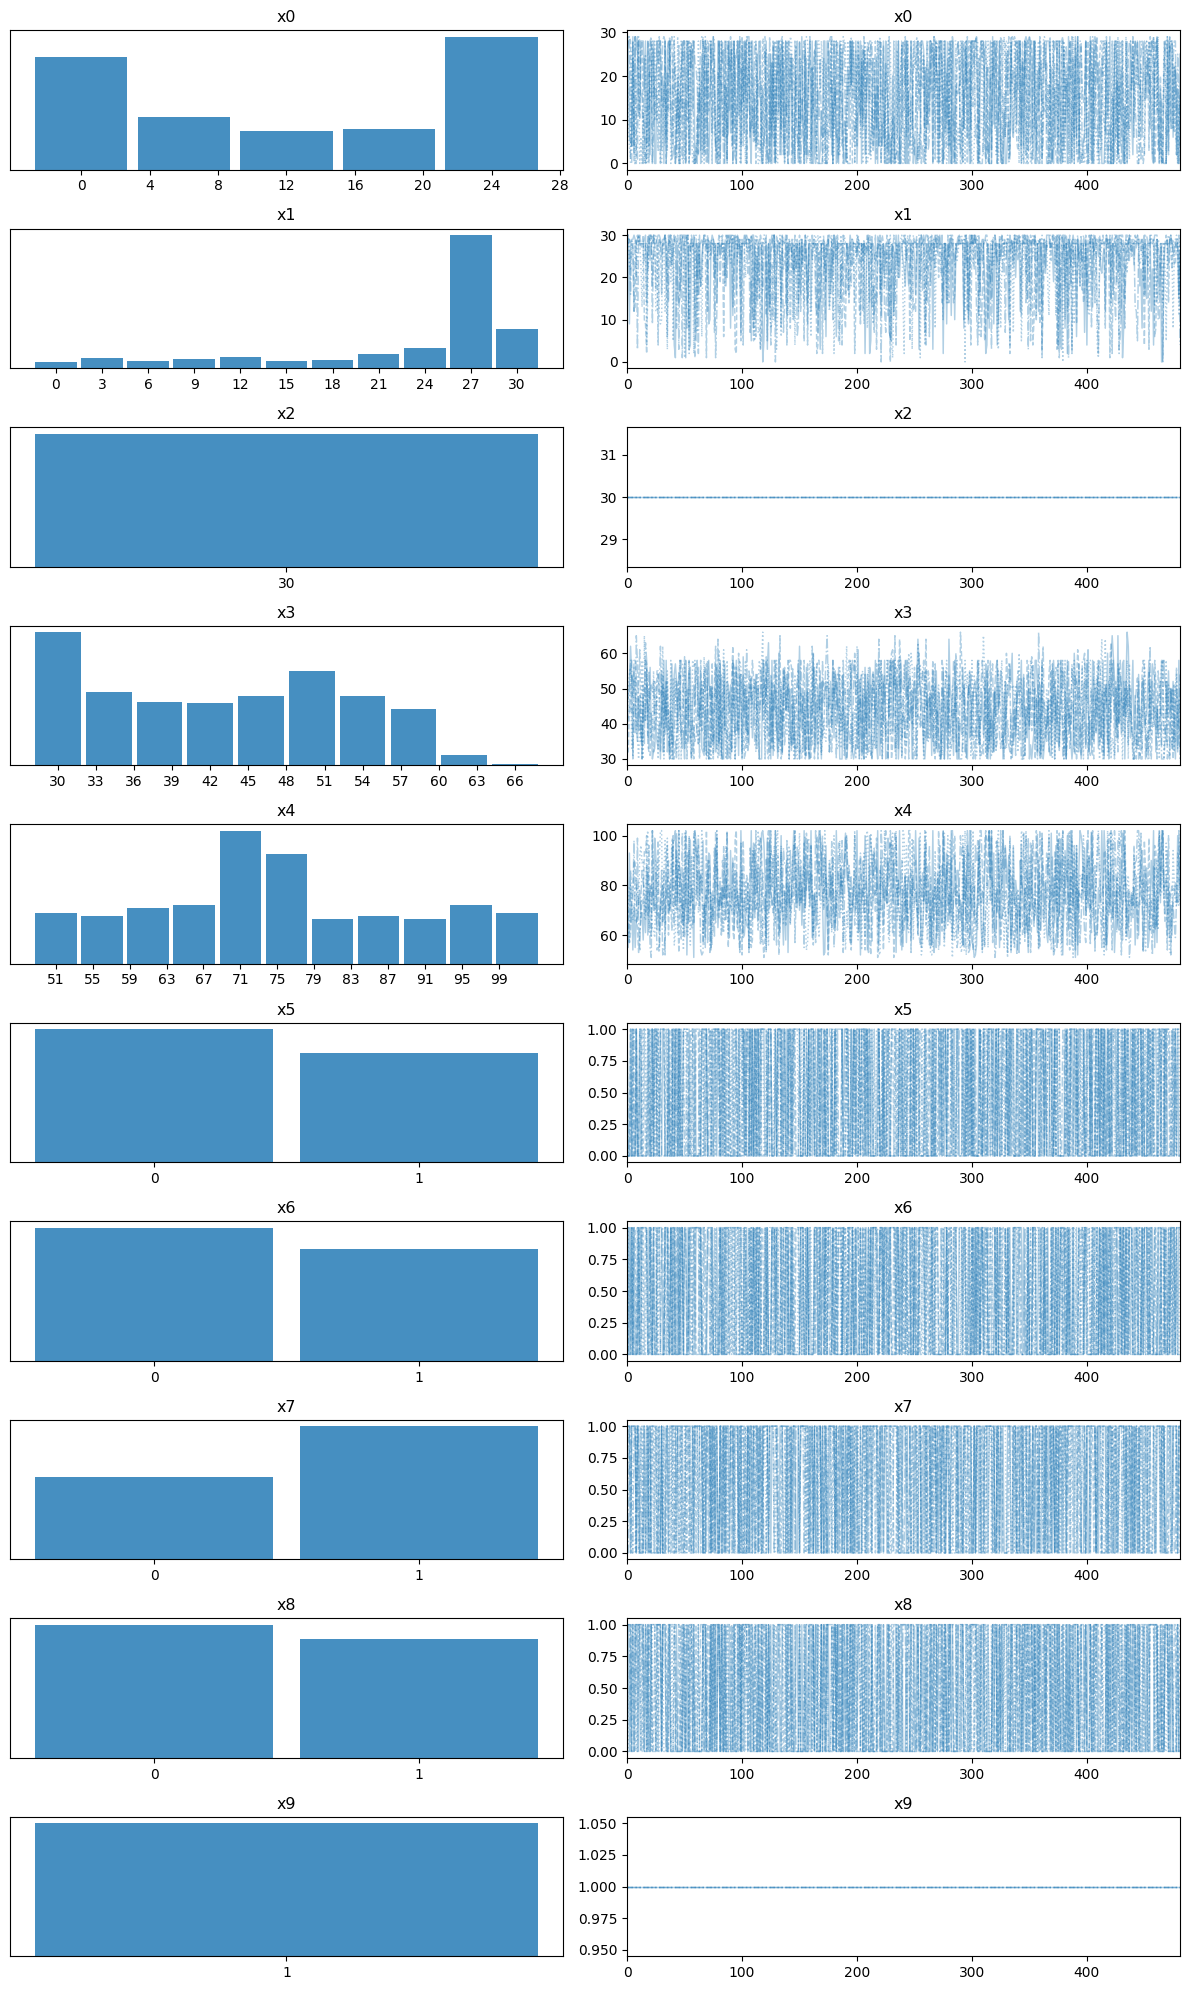

In [4]:
# Plot the posterior
az.plot_trace(trace);
plt.savefig('megasampler_trace_plot.png', dpi=150);

In [5]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,14.832,11.198,0.0,28.0,0.255,0.077,1939.0,1755.0,1.0
x1,23.834,8.008,5.0,30.0,0.185,0.164,1916.0,1807.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,NaN,1928.0,1928.0,NaN
x3,44.118,9.791,30.0,58.0,0.226,0.098,1918.0,1852.0,1.0
x4,77.216,14.167,55.0,102.0,0.340,0.175,1724.0,1718.0,1.0
x5,0.452,0.498,0.0,1.0,0.011,0.001,1945.0,1928.0,1.0
x6,0.456,0.498,0.0,1.0,0.012,0.001,1698.0,1698.0,1.0
x7,0.618,0.486,0.0,1.0,0.011,0.003,1930.0,1928.0,1.0
x8,0.473,0.499,0.0,1.0,0.012,0.001,1741.0,1741.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,NaN,1928.0,1928.0,NaN


In [6]:
utils.save_trace(trace, f'db_cacm_SMT_{num_vars}.nc')